<a href="https://colab.research.google.com/github/ahaditi/BDA-project/blob/main/Final_copy_BDA_project_Airline_Delay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import findspark 
findspark.init() 
findspark.find() 
import pyspark 
findspark.find()

'/usr/local/lib/python3.8/dist-packages/pyspark'

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [ ]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param, Params
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from IPython.display import display
from ipywidgets import interact
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path
import pyarrow as pa
from pyarrow import csv
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%matplotlib inline

In [ ]:
textFile = sc.textFile('/content/sample_data/2014Flightdata.csv')
textFileRDD = textFile.map(lambda x: x.split(','))
header = textFileRDD.first()
textRDD = textFileRDD.filter(lambda r: r != header)

In [ ]:
def parse(r):
    try:
        x=Row(Year=int(r[0]),\
          Month=int(r[1]),\
          DayofMonth=int(r[2]),\
          DayOfWeek=int(r[3]),\
          DepTime=int(float(r[8])), \
          CRSDepTime=int(r[7]),\
          ArrTime=int(float(r[11])),\
          CRSArrTime=int(r[10]), \
          UniqueCarrier=r[4],\
          DepDelay=int(float(r[9])),\
          Origin=r[5],\
          Dest=r[6], \
          Distance=int(float(r[12])),\
          CarrierDelay=int(float(r[13])),\
          WeatherDelay=int(float(r[14])),\
          NASDelay= int(float(r[15])),\
          SecurityDelay=int(float(r[16])),\
          LateAircraftDelay=int(float(r[17])))  
    except:
        x=None  
    return x

rowRDD = textRDD.map(lambda r: parse(r)).filter(lambda r:r != None)
sqlContext = SQLContext(sc)
airline_df = sqlContext.createDataFrame(rowRDD)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
airline_df = airline_df.withColumn('DepDelayed', airline_df['DepDelay']>15)

In [ ]:
# define hour function to obtain hour of day
def hour_ex(x): 
    h = int(str(int(x)).zfill(4)[:2])
    return h

sqlContext.udf.register("hour_ex_py",hour_ex, IntegerType())
f_udf = udf(hour_ex, IntegerType())

#CRSDepTime: scheduled departure time (local, hhmm)
airline_df = airline_df.withColumn('hour', f_udf(airline_df.CRSDepTime))
airline_df.registerTempTable("airlineDF")

In [ ]:
airline_df.head(n=5)

[Row(Year=2014, Month=9, DayofMonth=11, DayOfWeek=4, DepTime=1324, CRSDepTime=1315, ArrTime=1431, CRSArrTime=1410, UniqueCarrier='OO', DepDelay=9, Origin='SLC', Dest='LAX', Distance=590, CarrierDelay=9, WeatherDelay=0, NASDelay=12, SecurityDelay=0, LateAircraftDelay=0, DepDelayed=False, hour=13),
 Row(Year=2014, Month=9, DayofMonth=18, DayOfWeek=4, DepTime=1320, CRSDepTime=1315, ArrTime=1425, CRSArrTime=1410, UniqueCarrier='OO', DepDelay=5, Origin='SLC', Dest='LAX', Distance=590, CarrierDelay=3, WeatherDelay=0, NASDelay=10, SecurityDelay=0, LateAircraftDelay=2, DepDelayed=False, hour=13),
 Row(Year=2014, Month=9, DayofMonth=7, DayOfWeek=7, DepTime=1415, CRSDepTime=1315, ArrTime=1520, CRSArrTime=1410, UniqueCarrier='OO', DepDelay=60, Origin='SLC', Dest='LAX', Distance=590, CarrierDelay=2, WeatherDelay=0, NASDelay=10, SecurityDelay=0, LateAircraftDelay=58, DepDelayed=True, hour=13),
 Row(Year=2014, Month=9, DayofMonth=28, DayOfWeek=7, DepTime=1418, CRSDepTime=1315, ArrTime=1517, CRSArrTi

In [ ]:
cause_delay = sqlContext.sql("SELECT sum(WeatherDelay) Weather,sum(NASDelay) NAS,sum(SecurityDelay) Security,sum(LateAircraftDelay) lateAircraft,sum(CarrierDelay) Carrier\
                              FROM airlineDF ")

In [ ]:
df_cause_delay = cause_delay.toPandas()
df_cause_delay.head()

,Weather,NAS,Security,lateAircraft,Carrier
0,1248597,6599956,28142,10919643,8157769


In [ ]:
groupedDelay = sqlContext.sql("SELECT Origin, count(*) conFlight,avg(DepDelay) delay \
                                FROM airlineDF \
                                GROUP BY Origin")

df_origin = groupedDelay.toPandas()
df_origin.sort_values('delay',ascending=0).head()

,Origin,conFlight,delay
320,LMT,2,292.500000
290,WYS,5,119.000000
250,PPG,9,116.666667
302,EKO,19,106.157895
287,PLN,9,95.666667


In [ ]:
df = pd.read_csv('/content/sample_data/airports.dat', index_col=0,\
names = ['name', 'city', 'country','IATA','ICAO','lat','lng','alt','TZone','DST','Tz','air','Ourair'], \
            header=0)
del df['air']
del df['Ourair']
df.head()

,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby
6,Wewak International Airport,Wewak,Papua New Guinea,WWK,AYWK,-3.583830,143.669006,19,10,U,Pacific/Port_Moresby


In [ ]:
df_airports = pd.merge(df_origin, df, left_on = 'Origin', right_on = 'IATA')
df_airports.head()

,Origin,conFlight,delay,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
0,PSE,53,55.962264,Mercedita Airport,Ponce,Puerto Rico,PSE,TJPS,18.008301,-66.563004,29,-4,U,America/Puerto_Rico
1,MSY,2565,54.186355,Louis Armstrong New Orleans International Airport,New Orleans,United States,MSY,KMSY,29.993401,-90.258003,4,-6,A,America/Chicago
2,GEG,416,46.889423,Spokane International Airport,Spokane,United States,GEG,KGEG,47.619900,-117.533997,2376,-8,A,America/Los_Angeles
3,SNA,2263,48.642068,John Wayne Airport-Orange County Airport,Santa Ana,United States,SNA,KSNA,33.675701,-117.867996,56,-8,A,America/Los_Angeles
4,BUR,1026,49.603314,Bob Hope Airport,Burbank,United States,BUR,KBUR,34.200699,-118.359001,778,-8,A,America/Los_Angeles


In [ ]:
df_airports.sort_values('delay',ascending=0).head()

,Origin,conFlight,delay,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
320,LMT,2,292.500000,Crater Lake-Klamath Regional Airport,Klamath Falls,United States,LMT,KLMT,42.156101,-121.733002,4095,-8,A,America/Los_Angeles
290,WYS,5,119.000000,Yellowstone Airport,West Yellowstone,United States,WYS,KWYS,44.688400,-111.117996,6649,-7,A,America/Denver
250,PPG,9,116.666667,Pago Pago International Airport,Pago Pago,American Samoa,PPG,NSTU,-14.331000,-170.710007,32,-11,U,Pacific/Pago_Pago
302,EKO,19,106.157895,Elko Regional Airport,Elko,United States,EKO,KEKO,40.824902,-115.792000,5140,-8,A,America/Los_Angeles
287,PLN,9,95.666667,Pellston Regional Airport of Emmet County Airport,Pellston,United States,PLN,KPLN,45.570900,-84.796700,721,-5,A,America/New_York


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def zscore(x):
    return (x-np.average(x))/np.std(x)

In [ ]:
import os
os.environ['PROJ_LIB'] = r'C:\Users\spl2s\anaconda3\pkgs\proj4-5.2.0-\
ha925a31_1\Library\share'

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

Each marker is an airport.
Size of markers: Airport Traffic (larger means higher number of flights in year)
Color of markers: Average Flight Delay (Redder means longer delays)


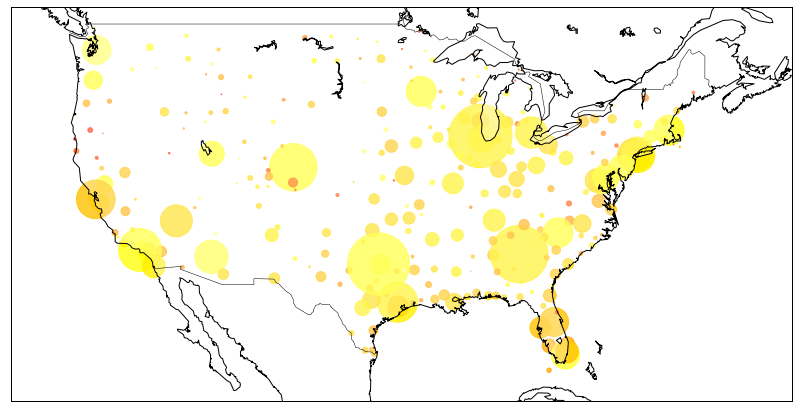

In [ ]:
rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 30))
colors=np.flipud(colors)

#----- Scatter -------
countrange=max(df_airports['conFlight'])-min(df_airports['conFlight'])
al=np.array([sigmoid(x) for x in zscore(df_airports['delay'])])
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
val=df_airports['conFlight']*4000.0/countrange

my_map.scatter(xs, ys,  marker='o', s= val, alpha = 0.8,color=colors[(al*20).astype(int)])

#----- Text -------
df_text=df_airports[(df_airports['conFlight']>60000) & (df_airports['IATA'] != 'HNL')]
xt,yt = my_map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))
txt=np.asarray(df_text['IATA'])
zp=zip(xt,yt,txt)
for row in zp:
    #print zp[2]
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each marker is an airport.")
print("Size of markers: Airport Traffic (larger means higher number of flights in year)")
print("Color of markers: Average Flight Delay (Redder means longer delays)")

plt.show()

In [ ]:
grp_rout_Delay = sqlContext.sql("SELECT Origin, Dest, count(*) traffic,avg(Distance) avgDist,\
                                    avg(DepDelay) avgDelay\
                                FROM airlineDF \
                                GROUP BY Origin,Dest")
rout_Delay = grp_rout_Delay.toPandas()

In [ ]:
df_airport_rout1 = pd.merge(rout_Delay, df, left_on = 'Origin', right_on = 'IATA')
df_airport_rout2 = pd.merge(df_airport_rout1, df, left_on = 'Dest', right_on = 'IATA')
df_airport_rout = df_airport_rout2[["Origin","lat_x","lng_x","Dest","lat_y","lng_y",\
                                    "avgDelay", "traffic"]]
df_airport_rout.sort_values('avgDelay',ascending=0).head()

,Origin,lat_x,lng_x,Dest,lat_y,lng_y,avgDelay,traffic
1152,JFK,40.639801,-73.778900,JAC,43.607300,-110.737999,322.0,1
1933,JAC,43.607300,-110.737999,JFK,40.639801,-73.778900,307.0,1
45,LMT,42.156101,-121.733002,PDX,45.588699,-122.598000,292.5,2
875,PIT,40.491501,-80.232903,MHT,42.932598,-71.435699,252.0,1
19,STL,38.748697,-90.370003,PDX,45.588699,-122.598000,245.0,1


Each line represents a route from the Origin to Destination airport.
The redder line, the higher probablity of delay.


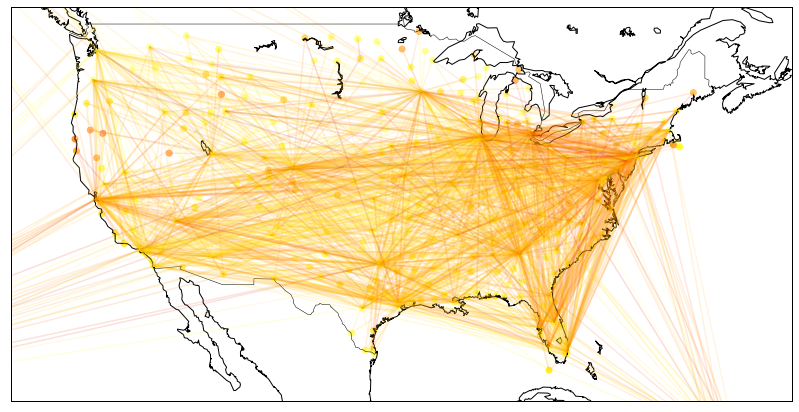

In [ ]:
rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

delay=np.array([sigmoid(x) for x in zscore(df_airports["delay"])])
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 40))
colors=np.flipud(colors)
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
xo,yo = my_map(np.asarray(df_airport_rout['lng_x']), np.asarray(df_airport_rout['lat_x']))
xd,yd = my_map(np.asarray(df_airport_rout['lng_y']), np.asarray(df_airport_rout['lat_y']))

my_map.scatter(xs, ys,  marker='o',  alpha = 0.8,color=colors[(delay*20).astype(int)])


al=np.array([sigmoid(x) for x in zscore(df_airport_rout["avgDelay"])])
f=zip(xo,yo,xd,yd,df_airport_rout['avgDelay'],al)
for row in f:
    plt.plot([row[0],row[2]], [row[1],row[3]],'-',alpha=0.07, \
             color=colors[(row[5]*30).astype(int)] )
    

for row in zp:
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each line represents a route from the Origin to Destination airport.")
print("The redder line, the higher probablity of delay.")
    
plt.show()

In [ ]:
Origin_Airport="SJC"

In [ ]:
df_ORG = sqlContext.sql("SELECT * from airlineDF WHERE origin='"+ Origin_Airport+"'")
df_ORG.registerTempTable("df_ORG")
df_ORG.select('ArrTime','CRSArrTime','CRSDepTime',\
              'DayOfWeek','DayofMonth','DepDelay','DepTime','Dest').show(2)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+-------+----------+----------+---------+----------+--------+-------+----+
|ArrTime|CRSArrTime|CRSDepTime|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|
+-------+----------+----------+---------+----------+--------+-------+----+
|   2025|      1710|      1338|        1|         8|     215|   1713| DEN|
|   1051|      1026|       655|        6|         6|      40|    735| DEN|
+-------+----------+----------+---------+----------+--------+-------+----+
only showing top 2 rows



In [ ]:
print("total flights from this airport: " + str(df_ORG.count()))

total flights from this airport: 2533


In [ ]:
grp_carr = sqlContext.sql("SELECT  UniqueCarrier,month, avg(DepDelay) avgDelay from df_ORG \
                            WHERE DepDelayed=True \
                            GROUP BY UniqueCarrier,month")
s = grp_carr.toPandas()

In [ ]:
ps = s.pivot(index='month', columns='UniqueCarrier', values='avgDelay')[['AA','UA','US']]

Text(0.5, 1.0, 'How much delay does each carrier has in each month?')

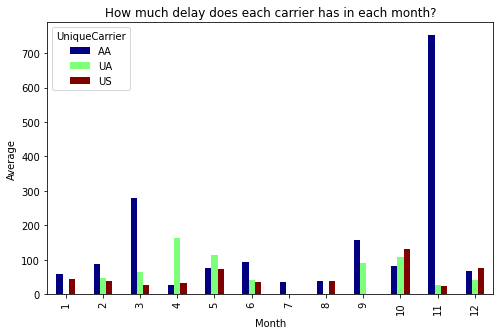

In [ ]:
rcParams['figure.figsize'] = (8,5)
ps.plot(kind='bar', colormap='jet');
plt.xlabel('Month')
plt.ylabel('Average')
plt.title('How much delay does each carrier has in each month?')

In [ ]:
hour_grouped = df_ORG.filter(df_ORG['DepDelayed']).select('DayOfWeek','hour','DepDelay').groupby('DayOfWeek','hour').mean('DepDelay')

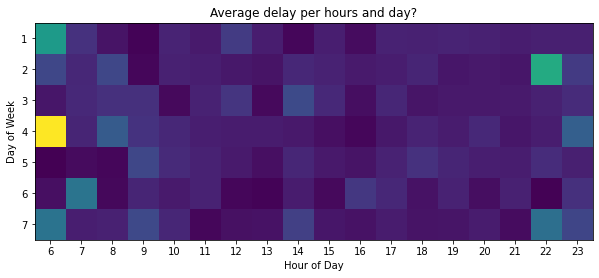

In [ ]:
rcParams['figure.figsize'] = (10,5)
dh = hour_grouped.toPandas()
c = dh.pivot('DayOfWeek','hour')
X = c.columns.levels[1].values
Y = c.index.values
Z = c.values
plt.xticks(range(0,24), X)
plt.yticks(range(0,7), Y)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Average delay per hours and day?')
plt.imshow(Z)

In [ ]:
Origin_Airport="SJC"

In [ ]:
df_ORG=sqlContext.sql("SELECT * from airlineDF WHERE Origin = '"+Origin_Airport+"'")
df_ORG.registerTempTable("df_ORG")

In [ ]:
#feature selction
df_model=df_ORG
stringIndexer1 = StringIndexer(inputCol="Origin", outputCol="originIndex")
model_stringIndexer = stringIndexer1.fit(df_model)
indexedOrigin = model_stringIndexer.transform(df_model)
encoder1 = OneHotEncoder(dropLast=False,inputCol="originIndex", outputCol="originVec")
ohe = encoder1.fit(indexedOrigin)
df_model = ohe.transform(indexedOrigin)

In [ ]:
assembler = VectorAssembler(
    inputCols = ['Year','Month','DayofMonth','DayOfWeek','hour','Distance','originVec'],
    outputCol = "features")
output = assembler.transform(df_model)

In [ ]:
from pyspark.mllib import linalg as mllib_linalg
from pyspark.ml import linalg as ml_linalg
from pyspark.sql.functions import col
def as_old(v):
    if isinstance(v, ml_linalg.SparseVector):
        return mllib_linalg.SparseVector(v.size, v.indices, v.values)
    if isinstance(v, ml_linalg.DenseVector):
        return mllib_linalg.DenseVector(v.values)
    raise ValueError("Unsupported type {0}".format(type(v)))
airlineRDD=output.select(col("DepDelayed").alias("label"), col("features"))\
            .rdd\
            .map(lambda row: LabeledPoint(row.label, as_old(row.features)))

In [ ]:
airlineRDD.take(2)

[LabeledPoint(1.0, [2014.0,9.0,8.0,1.0,13.0,948.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,6.0,6.0,6.0,948.0,1.0])]

In [ ]:
#  Spliting dataset into train and test dtasets
trainRDD,testRDD=airlineRDD.randomSplit([0.7,0.3])

In [ ]:
# Build the model
model = LogisticRegressionWithLBFGS.train(trainRDD)

In [ ]:
# Evaluating the model on testing data
labelsAndPreds = testRDD.map(lambda p: (p.label, model.predict(p.features)))
labelsAndPreds.take(2)

[(1.0, 1), (1.0, 1)]

In [ ]:
trainErr = labelsAndPreds.filter(lambda lp: lp[0] != lp[1]).count() / float(testRDD.count())
print("Training Error = " + str(trainErr))

Training Error = 0.17721518987341772


In [ ]:
testRDD.take(10)

[LabeledPoint(1.0, [2014.0,9.0,1.0,1.0,18.0,296.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,1.0,1.0,20.0,296.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,1.0,1.0,19.0,386.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,1.0,1.0,10.0,308.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,1.0,1.0,14.0,417.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,17.0,3.0,20.0,296.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,17.0,3.0,14.0,386.0,1.0]),
 LabeledPoint(0.0, [2014.0,9.0,17.0,3.0,12.0,308.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,17.0,3.0,20.0,333.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,19.0,5.0,14.0,386.0,1.0])]

In [ ]:
def conf(r):
    if r[0] == r[1] ==1: x= 'TP'
    if r[0] == r[1] ==0: x= 'TN'
    if r[0] == 1 and  r[1] ==0: x= 'FN'
    if r[0] == 0 and  r[1] ==1: x= 'FP'
    return (x)
acc1 = labelsAndPreds.map(lambda vp: ((vp[1], vp[0]), 1)).reduceByKey(lambda a, b: a + b).take(5)
acc = [(conf(x[0]),x[1]) for x in acc1]

In [ ]:
for x in range(len(acc)): 
    print (acc[x])

('TN', 9)
('FN', 140)
('TP', 641)


In [ ]:
TP=TN=FP=FN=0.0
for x in acc: 
    if x[0]=='TP': TP= x[1]
    if x[0]=='TN': TN= x[1]
    if x[0]=='FP': FP= x[1]
    if x[0]=='FN': FN= x[1]
eps = sys.float_info.epsilon
Accuracy = (TP+TN) / (TP + TN+ FP+FN+eps) 
print("Model Accuracy for SJC:")
print(float(Accuracy*100))

Model Accuracy for SJC:
82.27848101265823
